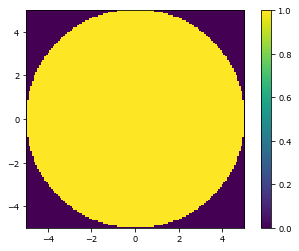

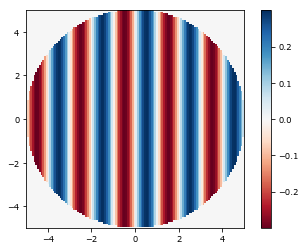

In [1]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

N = 128
padding = 1

D_keck = 9.96
keck_aperture = circular_aperture(D_keck)
pupil_grid = make_pupil_grid(N, D_keck * padding)

wf = Wavefront(keck_aperture(pupil_grid))

aberrated = wf.copy()
amplitude = 0.3
spatial_frequency = 5
aberrated.electric_field *= np.exp(1j * amplitude * np.sin(2*np.pi * pupil_grid.x / D_keck * spatial_frequency))

imshow_field(wf.intensity)
plt.colorbar()
plt.show()

imshow_field(aberrated.phase, cmap='RdBu')
plt.colorbar()
plt.show()

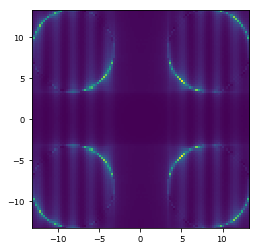

In [2]:
sps = 40 #sub-pupil size
pupsep = 65/39.3
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
pyramid_grid = make_pupil_grid(N, 3.6e-3)
pyramid_output = keck_pyramid.forward(aberrated).intensity
imshow_field(pyramid_output)
plt.show()

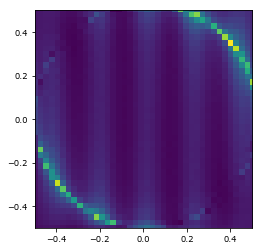

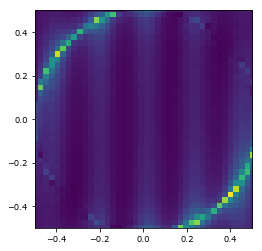

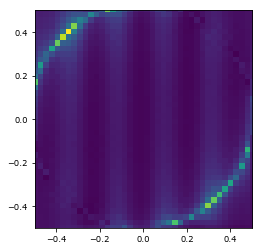

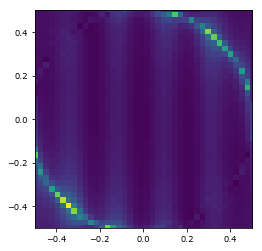

In [3]:
outgrid = np.zeros((N, N)).tolist()
pyramid_output.shape = (outgrid_size, outgrid_size)
buffer = (N - outgrid_size)//2
for rownum, row in enumerate(pyramid_output.tolist()):
    for colnum, el in enumerate(row):
        outgrid[rownum+buffer][colnum+buffer] = el
images = Field(np.asarray(outgrid).ravel(), pyramid_grid)
image = images.shaped
sub_images = [image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)], 
              image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
              image[buffer:sps+buffer, buffer:sps+buffer],
              image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)]]
sub_images = [image[buffer:sps+buffer, buffer:sps+buffer], 
              image[(N-buffer-sps-1):(N-buffer-1), buffer:sps+buffer],
              image[buffer:sps+buffer, (N-buffer-sps-1):(N-buffer-1)], 
              image[(N-buffer-sps-1):(N-buffer-1), (N-buffer-sps-1):(N-buffer-1)]]
subimage_grid = make_pupil_grid(sps)
for count, img in enumerate(sub_images):
    img = img.ravel()
    img.grid = subimage_grid
    sub_images[count] = img
    imshow_field(img)
    plt.show()

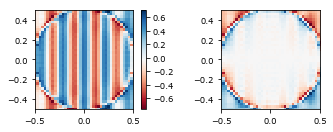

In [4]:
def estimate(EstimatorObject, images_list):
    '''
    Slightly edited version of the PWFSEstimator.estimate function. The earlier function had a difference in sub-pupil
    numbering compared to the literature I found. As implemented before, it was 
    a b
    c d
    but according to papers such as https://ui.adsabs.harvard.edu/#abs/2006OExpr..1411925B/abstract (page 3) it's
    b a
    c d
    '''
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    # dummy = Field(np.zeros(I_x.size), I_x.grid)
    I_x = I_x.ravel()
    I_y = I_y.ravel()
    # dummy = dummy.ravel()
    # res = Field([I_x, I_y, dummy], EstimatorObject.pupil_mask.grid)
    # previously, was not possible to plot res, can now do so as a red-green plot (red = x and green = y).
    return I_x, I_y

pyramid_subgrid = make_pupil_grid(sps*2, (3.6e-3)*sps*2/N)
keck_pyramid_estimator = PyramidWavefrontSensorEstimator(keck_aperture, pyramid_subgrid)
x_slopes, y_slopes = estimate(keck_pyramid_estimator, sub_images)
plt.subplot(2,2,1)
imshow_field(x_slopes, cmap='RdBu') #, vmax=0.005, vmin=-0.005)
plt.colorbar()
plt.subplot(2,2,2)
imshow_field(y_slopes, cmap='RdBu') #, vmax=0.005, vmin=-0.005)
plt.show()


In [5]:
s = np.concatenate((x_slopes, y_slopes))

In [6]:
D_grid = 3.6e-3
def make_inversion_matrix(N):
    aperture = keck_aperture
    wf = Wavefront(aperture(pupil_grid))
    wf.electric_field.shape = (N, N)

    print("Making an aberration basis...")
    aberration_mode_basis = []
    try:
        for i in range(N):
            for j in range(N):
                l = wf.electric_field.tolist()
                if np.real(l[i][j]) > 0:
                    l[i][j] = 0
                    aberration_mode_basis.append(Wavefront(Field(np.round(np.asarray(l).ravel(), 3), wf.grid)))
        basis_size = len(aberration_mode_basis)
        print(basis_size)
    except KeyboardInterrupt:
        print(len(aberration_mode_basis))

    print("Propagating to pyramid, please wait...")
    # Propagating to pyramid. (Longest step, about 8-9 minutes, and probably also O(N^2) so 36 minutes for N=256)
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    pyramid_output_basis = []
    for index, x in enumerate(aberration_mode_basis):
        if index % 1000 == 0:
            print(index)
        pyramid_output_basis.append(keck_pyramid.forward(x))

    def get_sub_images(intensity):
        pyramid_grid = make_pupil_grid(N, D_grid)
        images = Field(np.asarray(intensity).ravel(), pyramid_grid)
        pysize = int(np.sqrt(images.size))
        images.shape = (pysize, pysize)
        sub_images = [images[0:sps, 0:sps], images[pysize-sps-1:pysize-1, 0:sps],
                      images[0:sps, pysize-sps-1:pysize-1], images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1]]
        subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
        for count, img in enumerate(sub_images):
            img = img.ravel()
            img.grid = subimage_grid
            sub_images[count] = img
        return sub_images

    print("Extracting sub-images...")
    sub_images_basis = [get_sub_images(x.intensity) for x in pyramid_output_basis]

    def estimate(EstimatorObject, images_list):
        # Restored the numbering convention to what it was originally because this version of sub_images handles it.
        I_a = images_list[0]
        I_b = images_list[1]
        I_c = images_list[2]
        I_d = images_list[3]
        norm = I_a + I_b + I_c + I_d
        I_x = (I_a + I_b - I_c - I_d) / norm
        I_y = (I_a - I_b - I_c + I_d) / norm
        return [I_x.ravel(), I_y.ravel()]

    print("Estimating...")
    keck_pyramid_estimator = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
    estimated_basis = [estimate(keck_pyramid_estimator, x) for x in sub_images_basis]

    print("Doing all of the above for a flat wavefront...")
    # All the above steps, to generate flat wavefront slopes
    flat_mode = Wavefront(aperture(pupil_grid))
    flat_pyramid_output = keck_pyramid.forward(flat_mode)
    flat_x, flat_y = estimate(keck_pyramid_estimator, get_sub_images(flat_pyramid_output.intensity))

    print("Constructing the estimated basis...")
    estimated_x, estimated_y, est = [], [], []
    for x, y in estimated_basis:
        estimated_x.append(np.asarray(x - flat_x).ravel())
        estimated_y.append(np.asarray(y - flat_y).ravel())
    print(np.asarray(estimated_x).shape)
    print(np.asarray(estimated_y).shape)
    estimated_x = np.asarray(estimated_x)
    estimated_y = np.asarray(estimated_y)
    i = 0
    while i < estimated_x.shape[0]:
        est.append(np.concatenate((estimated_x[i], estimated_y[i])))
        i += 1

    print("Checking that the size is okay...")
    try:
        assert(np.asarray(est).shape == (basis_size, 2*sps*sps))
        return np.asarray(est)
    except AssertionError:
        print("oops")
        print(np.asarray(est).shape)
        print((basis_size, 2*sps*sps))

M = make_inversion_matrix(N)

Making an aberration basis...
12644
Propagating to pyramid, please wait...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Extracting sub-images...
Estimating...
Doing all of the above for a flat wavefront...
Constructing the estimated basis...
(12644, 1600)
(12644, 1600)
Checking that the size is okay...


In [7]:
M = M.T
MT = M.T

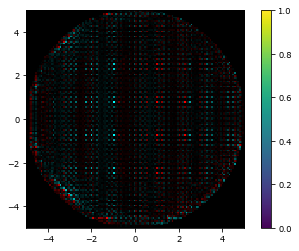

In [8]:
# M = 12644 x 3200, you can multiply in a 3200 x 1 matrix (the slopes)
# and get something that's 12644 x 1 which can be plotted on a 128 x 128 aperture
        
def plot_on_aperture(aperture, field):
    project_onto = Wavefront(aperture(pupil_grid)).electric_field
    project_onto.shape = (N, N)

    count, i, j = 0, 0, 0
    while count < 12644:
        if np.real(project_onto[i][j]) > 0:
            project_onto[i][j] = field[count]
            count += 1
        j += 1
        if j == N - 1:
            j = 0
            i += 1
    return project_onto.ravel() * aperture(pupil_grid)

imshow_field(plot_on_aperture(keck_aperture, MT.dot(s)), pupil_grid)
plt.colorbar()
plt.show()

In [9]:
# x = (A^T A)^(-1) A^T b
# reconstructed wf = (MT.dot(M)).inv.dot(MT).dot(slopes)

x1 = np.linalg.inv(MT.dot(M))

In [10]:
x2 = x1.dot(MT)

In [11]:
z = x2.dot(s)

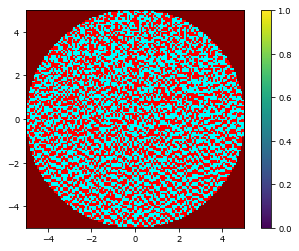

In [12]:
imshow_field(plot_on_aperture(keck_aperture, z), pupil_grid, vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.show()

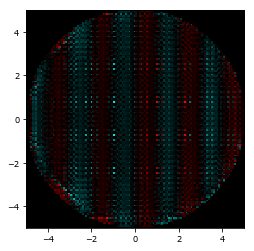

In [14]:
imshow_field(plot_on_aperture(keck_aperture, MT.dot(s)) * 5 + aberrated.phase, pupil_grid)
plt.show()

In [15]:
def plot_reconstructed(z, r=0.05):
    imshow_field(plot_on_aperture(keck_aperture, z), pupil_grid, vmin=-r, vmax=r)
    plt.show()

In [16]:
M.shape

(3200, 12644)

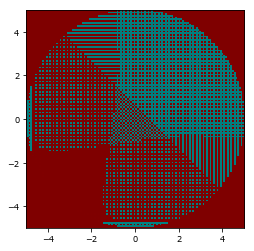

In [26]:
plot_reconstructed(M[3199])

In [27]:
D_grid = 3.6e-3
def invert_no_flat(N):
    aperture = keck_aperture
    wf = Wavefront(aperture(pupil_grid))
    wf.electric_field.shape = (N, N)

    print("Making an aberration basis...")
    aberration_mode_basis = []
    try:
        for i in range(N):
            for j in range(N):
                l = wf.electric_field.tolist()
                if np.real(l[i][j]) > 0:
                    l[i][j] = 0
                    aberration_mode_basis.append(Wavefront(Field(np.round(np.asarray(l).ravel(), 3), wf.grid)))
        basis_size = len(aberration_mode_basis)
        print(basis_size)
    except KeyboardInterrupt:
        print(len(aberration_mode_basis))

    print("Propagating to pyramid, please wait...")
    # Propagating to pyramid. (Longest step, about 8-9 minutes, and probably also O(N^2) so 36 minutes for N=256)
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    pyramid_output_basis = []
    for index, x in enumerate(aberration_mode_basis):
        if index % 1000 == 0:
            print(index)
        pyramid_output_basis.append(keck_pyramid.forward(x))

    def get_sub_images(intensity):
        pyramid_grid = make_pupil_grid(N, D_grid)
        images = Field(np.asarray(intensity).ravel(), pyramid_grid)
        pysize = int(np.sqrt(images.size))
        images.shape = (pysize, pysize)
        sub_images = [images[0:sps, 0:sps], images[pysize-sps-1:pysize-1, 0:sps],
                      images[0:sps, pysize-sps-1:pysize-1], images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1]]
        subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
        for count, img in enumerate(sub_images):
            img = img.ravel()
            img.grid = subimage_grid
            sub_images[count] = img
        return sub_images

    print("Extracting sub-images...")
    sub_images_basis = [get_sub_images(x.intensity) for x in pyramid_output_basis]

    def estimate(EstimatorObject, images_list):
        # Restored the numbering convention to what it was originally because this version of sub_images handles it.
        I_a = images_list[0]
        I_b = images_list[1]
        I_c = images_list[2]
        I_d = images_list[3]
        norm = I_a + I_b + I_c + I_d
        I_x = (I_a + I_b - I_c - I_d) / norm
        I_y = (I_a - I_b - I_c + I_d) / norm
        return [I_x.ravel(), I_y.ravel()]

    print("Estimating...")
    keck_pyramid_estimator = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
    estimated_basis = [estimate(keck_pyramid_estimator, x) for x in sub_images_basis]

    print("Constructing the estimated basis...")
    estimated_x, estimated_y, est = [], [], []
    for x, y in estimated_basis:
        estimated_x.append(np.asarray(x).ravel())
        estimated_y.append(np.asarray(y).ravel())
    print(np.asarray(estimated_x).shape)
    print(np.asarray(estimated_y).shape)
    estimated_x = np.asarray(estimated_x)
    estimated_y = np.asarray(estimated_y)
    i = 0
    while i < estimated_x.shape[0]:
        est.append(np.concatenate((estimated_x[i], estimated_y[i])))
        i += 1

    print("Checking that the size is okay...")
    try:
        assert(np.asarray(est).shape == (basis_size, 2*sps*sps))
        return np.asarray(est)
    except AssertionError:
        print("oops")
        print(np.asarray(est).shape)
        print((basis_size, 2*sps*sps))

P_i = make_inversion_matrix(N)

Making an aberration basis...
12644
Propagating to pyramid, please wait...
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Extracting sub-images...
Estimating...
Doing all of the above for a flat wavefront...
Constructing the estimated basis...
(12644, 1600)
(12644, 1600)
Checking that the size is okay...


In [37]:
def least_inv(A):
    # given a matrix A such that Ax = b, makes a least-squares matrix Y such that
    # x^ = Yb.
    return np.linalg.inv(A.T.dot(A)).dot(A.T)

In [38]:
M_rough = np.round(M, 3)

In [42]:
P = least_inv(M)

In [43]:
P.shape

(3200, 12644)

In [54]:
def slopes_from_matrix_output(s, r=1):
    s_grid = make_pupil_grid(sps)
    plt.subplot(2,2,1)
    imshow_field(s[0:sps*sps], s_grid, vmin=-r, vmax=r)
    plt.subplot(2,2,2)
    imshow_field(s[sps*sps:2*sps*sps], s_grid, vmin=-r, vmax=r)
    plt.show()

In [51]:
wf = Wavefront(keck_aperture(pupil_grid))

In [52]:
wf.intensity[wf.intensity > 0].shape

(12644,)

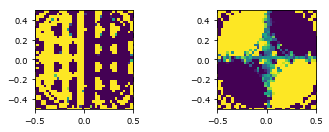

In [55]:
slopes_from_matrix_output(P.dot(wf.intensity[wf.intensity > 0]), 0.05)

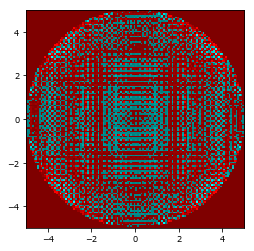

In [60]:
plot_reconstructed(M.dot(P.dot(wf.intensity[wf.intensity > 0])), 1)

In [61]:
c = wf.intensity[wf.intensity > 0] - M.dot(P.dot(wf.intensity[wf.intensity > 0]))

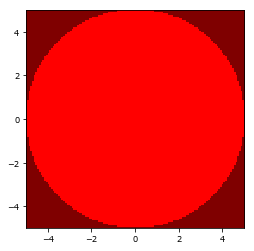

In [62]:
plot_reconstructed(M.dot(P.dot(wf.intensity[wf.intensity > 0])) + c)

In [64]:
(M.dot(P.dot(wf.intensity[wf.intensity > 0])) + c)

Field(0.9999999999999998)

In [65]:
reconstruct_corrected = lambda z: z + c

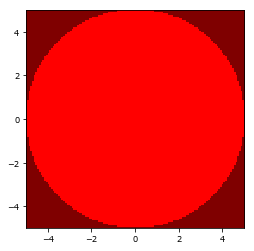

In [67]:
plot_reconstructed(reconstruct_corrected(M.dot(P.dot(wf.intensity[wf.intensity > 0]))))
plot_corrected = lambda z: plot_reconstructed(reconstruct_corrected(z))

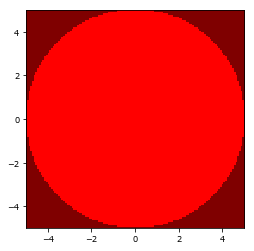

In [68]:
plot_corrected(M.dot(P.dot(wf.intensity[wf.intensity > 0])))

In [81]:
def make_aberration_basis(N):
    corrections = []
    wf = Wavefront(keck_aperture(pupil_grid))
    wf.electric_field.shape = (N, N)
    for i in range(N):
        for j in range(N):
            l = wf.electric_field.tolist()
            if np.real(l[i][j]) > 0:
                l[i][j] = 0
                corrections.append(Wavefront(Field(np.round(np.asarray(l).ravel(), 3), wf.grid)))
    return corrections
                
corrections = make_aberration_basis(N)

In [82]:
correct_wf = lambda z: reconstruct_corrected(M.dot(P.dot(z.intensity[wf.intensity > 0])))

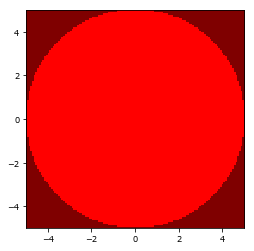

In [107]:
plot_reconstructed(correct_wf(corrections[9000]))

-1.0


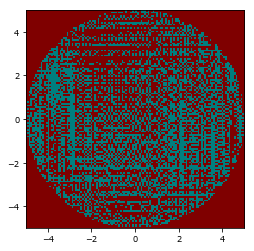

In [120]:
print(min(corrections[0].intensity - wf.intensity))
plot_reconstructed(M.dot(P.dot(corrections[50].intensity[wf.intensity > 0])) - M.dot(P.dot(wf.intensity[wf.intensity > 0])), 1)
